<a href="https://colab.research.google.com/github/siva-sankar-a/eva_final_project/blob/master/EVA_S15_Part2_Unet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
!pip install torchviz
!pip install kornia
!pip install -U git+https://github.com/albu/albumentations --no-cache-dir
%load_ext autoreload
%autoreload 2

     |████████████████████████████████| 51kB 2.4MB/s 
  Created wheel for torchviz: filename=torchviz-0.0.1-cp36-none-any.whl size=3523 sha256=9a462c6d8484e138142fbb89b3979694069c1e658aa9169c2044b2eb6d33ec0f
  Stored in directory: /root/.cache/pip/wheels/2a/c2/c5/b8b4d0f7992c735f6db5bfa3c5f354cf36502037ca2b585667
Successfully built torchviz
     |████████████████████████████████| 163kB 3.4MB/s 
  Cloning https://github.com/albu/albumentations to /tmp/pip-req-build-wagtjjkp
  Running command git clone -q https://github.com/albu/albumentations /tmp/pip-req-build-wagtjjkp
     |████████████████████████████████| 634kB 3.5MB/s 
  Created wheel for albumentations: filename=albumentations-0.4.5-cp36-none-any.whl size=65038 sha256=49c0ff7800622251a68d9b1b78b67a1267cd9c29aa78bda13e59a1e9fb935efe
  Stored in directory: /tmp/pip-ephem-wheel-cache-1qvsdx52/wheels/45/8b/e4/2837bbcf517d00732b8e394f8646f22b8723ac00993230188b
  Created wheel for imgaug: filename=imgaug-0.2.6-cp36-none-any.whl size=654

In [0]:
import subprocess
import urllib
import cv2
import os
import glob
import datetime
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd

from kornia.losses import SSIM

import torch
import torchvision
from torchsummary import summary 
from torchviz import make_dot
from torch.utils.data import Dataset, DataLoader
from torchvision.datasets.utils import download_url, download_and_extract_archive

from albumentations import Compose, Rotate, HorizontalFlip, Normalize, RandomCrop, Cutout, PadIfNeeded, Lambda, Resize
from albumentations.pytorch import ToTensor

from PIL import Image

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torchvision import datasets, transforms
import torchvision.models as models

from torch.utils.tensorboard import SummaryWriter
from torch.autograd import Variable
from torch.optim.lr_scheduler import StepLR, CyclicLR, ReduceLROnPlateau

import tensorflow as tf

from tqdm import tqdm

from multiprocessing import Process
from zipfile import ZipFile, ZIP_DEFLATED

In [0]:
experiment_name = 'eva_final_project'

In [0]:
class FgBgDataset(Dataset):
  """
  Custom class to load foreground background image dataset
  """
  def __init__(self, no_of_parts=10, 
               fg_bg_train_transform=None, 
               bg_train_transform=None, 
               fg_bg_test_transform=None, 
               bg_test_transform=None,
               target_transform=None, 
               mask_transform = None,
               depth_transform = None,
               **kwargs):
    """
    Constructor for foreground background image dataset
    """
    super().__init__(**kwargs)

    self.ROOT_URL = 'https://eva-final-project-dataset.s3-ap-southeast-2.amazonaws.com/'
    self.COMPRESSED_DIR = './compressed'
    self.DATASET_DIR = './dataset'
    self.DATASET_INFO_FILE = 'dataset_info.csv'
    self.DATASET_FILE_PREFIX = 'dataset_'

    self.no_of_parts = no_of_parts
    self.dataset_info_file_path = os.path.join(self.DATASET_DIR, self.DATASET_INFO_FILE)

    self.download_dataset()

    self.df = pd.read_csv(self.dataset_info_file_path)

    self.train = True
    self.fg_bg_train_transform = fg_bg_train_transform 
    self.bg_train_transform = bg_train_transform 
    self.fg_bg_test_transform = fg_bg_test_transform 
    self.bg_test_transform = bg_test_transform

    self.mask_transform = mask_transform
    self.depth_transform = depth_transform

    self.is_random_crop = False

  def download_dataset(self):
    if not os.path.exists(self.DATASET_DIR):
      print('Downloading dataset..')
      os.mkdir(self.DATASET_DIR)
      if not os.path.exists(self.COMPRESSED_DIR):
        os.mkdir(self.COMPRESSED_DIR)

      dataset_info_url = urllib.parse.urljoin(self.ROOT_URL, self.DATASET_INFO_FILE)
      download_url(dataset_info_url, self.DATASET_DIR, self.DATASET_INFO_FILE)
      dataset_info_url = urllib.parse.urljoin(self.ROOT_URL, self.DATASET_INFO_FILE)

      processes = [Process(target=self.download_and_extract_part, args=(part_idx,)) for part_idx in range(self.no_of_parts)]
      processes.append(Process(target=self.download_and_extract_bg))
      for process in processes:
        process.start()
      for process in processes:
        process.join()
    else:
      print('Dataset found!')

  def download_and_extract_part(self, part):
    dataset_part_path = f'{self.DATASET_FILE_PREFIX}{part}.zip'
    dataset_part_url = urllib.parse.urljoin(self.ROOT_URL, dataset_part_path)
    download_and_extract_archive(dataset_part_url, self.COMPRESSED_DIR, self.DATASET_DIR)
  
  def download_and_extract_bg(self):
    bg_path = f'bg_cropped.zip'
    bg_url = urllib.parse.urljoin(self.ROOT_URL, bg_path)
    download_and_extract_archive(bg_url, self.COMPRESSED_DIR, self.DATASET_DIR)

  def __len__(self):
      return len(self.df)

  def set_train(self):
      self.train = True

  def set_eval(self):
      self.train = False

  def __getitem__(self, index):

    H = 1024
    W = 1024

    required_height = 256
    required_width = 256

    if torch.is_tensor(index):
      index = index.tolist()

    fg_bg_path = os.path.join(self.DATASET_DIR, self.df['fg_bg_paths'].iloc[index])
    bg_path = os.path.join(self.DATASET_DIR, self.df['selected_bg_paths'].iloc[index])
    mask_path = os.path.join(self.DATASET_DIR, self.df['mask_paths'].iloc[index])
    depth_map_path = os.path.join(self.DATASET_DIR, self.df['depth_map_paths'].iloc[index])

    fg_bg_img = cv2.imread(fg_bg_path)
    fg_bg_img = cv2.cvtColor(fg_bg_img, cv2.COLOR_BGR2RGB)

    bg_img = cv2.imread(bg_path)
    bg_img = cv2.cvtColor(bg_img, cv2.COLOR_BGR2RGB)

    mask_img = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
    _, mask_img = cv2.threshold(mask_img, thresh=127, maxval=255, type=cv2.THRESH_BINARY)
    depth_img = cv2.imread(depth_map_path, cv2.IMREAD_GRAYSCALE)

    if self.is_random_crop:
      r_min = 0
      r_max = H - required_height

      c_min = 0
      c_max = W - required_width

      if self.train:
        r = np.random.randint(r_min, r_max)
        c = np.random.randint(c_min, c_max)
      else:
        r = 0
        c = 0

      fg_bg_img = fg_bg_img[r:r + required_height, c:c + required_width, :]
      bg_img = bg_img[r:r + required_height, c:c + required_width, :]
      mask_img = mask_img[r:r + required_height, c:c + required_width]
      depth_img = depth_img[(r // 2):(r + required_height) // 2, (c // 2):(c + required_width) // 2]
    else:
      fg_bg_img = cv2.resize(fg_bg_img, (required_height, required_height), cv2.INTER_CUBIC)
      bg_img = cv2.resize(bg_img, (required_height, required_height), cv2.INTER_CUBIC)

    mask_minimal = cv2.resize(mask_img, (128, 128), cv2.INTER_CUBIC)
    depth_minimal = cv2.resize(depth_img, (128, 128), cv2.INTER_CUBIC)

    mask_img = np.expand_dims(mask_img, axis=2)
    depth_img = np.expand_dims(depth_img, axis=2)
    
    mask_minimal = np.expand_dims(mask_minimal, axis=2)
    depth_minimal = np.expand_dims(depth_minimal, axis=2)

    is_camel = (mask_img > 128).flatten().any()
    # print(fg_bg_img.shape, bg_img.shape, mask_img.shape, depth_img.shape)

    if self.train:
      if self.fg_bg_train_transform:
        augmented = self.fg_bg_train_transform(image=fg_bg_img)
        fg_bg_img = augmented['image']
      if self.bg_train_transform:
        augmented = self.bg_train_transform(image=bg_img)
        bg_img = augmented['image']
    else:
      if self.fg_bg_test_transform:
        augmented = self.fg_bg_test_transform(image=fg_bg_img)
        fg_bg_img = augmented['image']
      if self.bg_test_transform:
        augmented = self.bg_test_transform(image=bg_img)
        bg_img = augmented['image']

    if self.depth_transform is not None:
        # augmented = self.depth_transform(image=depth_img)
        # depth_img = augmented['image']

        augmented = self.depth_transform(image=depth_minimal)
        depth_minimal = augmented['image']

    if self.mask_transform is not None:
        # augmented = self.mask_transform(image=mask_img)
        # mask_img = augmented['image']

        augmented = self.mask_transform(image=mask_minimal)
        mask_minimal = augmented['image']
    
    return { 'fg_bg': fg_bg_img, 'mask': mask_img, 'depth': depth_img, 'bg': bg_img, 
             'is_camel': is_camel, 'mask_minimal': mask_minimal, 'depth_minimal': depth_minimal
            }

In [0]:
def padded_random_crop_fg_bg(x, **kwargs):
    x = PadIfNeeded(min_height=72, min_width=72, border_mode=4,
                    value=None, mask_value=None, always_apply=True).apply(x)
    x = RandomCrop(height=64, width=64, always_apply=True).apply(x)
    return x

In [0]:
fg_bg_train_transform = Compose([Normalize(
                                    mean=[0.4561, 0.3984, 0.3620],
                                    std=[0.2866, 0.2640, 0.2774],
                                ),
                                ToTensor()
                            ])
bg_train_transform = Compose([Normalize(
                                    mean=[0.4547, 0.4028, 0.3705],
                                    std=[0.2920, 0.2662, 0.2803],
                                ),
                                ToTensor()
                            ])
mask_transform = Compose([ToTensor()])
depth_transform = Compose([Normalize(
                                    mean=[0.6289],
                                    std=[0.2238],
                                ),
                           ToTensor()])
fg_bg_test_transform = Compose([ToTensor()])
bg_test_transform = Compose([ToTensor()])

In [0]:
dataset = FgBgDataset(fg_bg_train_transform=fg_bg_train_transform,
                      bg_train_transform=bg_train_transform,
                      fg_bg_test_transform=fg_bg_test_transform, 
                      bg_test_transform=bg_test_transform, 
                      mask_transform=mask_transform, 
                      depth_transform=depth_transform)
batch_size = 4
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
dataloader_args = dict(shuffle=True, batch_size=batch_size, num_workers=4, pin_memory=True) if use_cuda else dict(shuffle=True, batch_size=batch_size)
data_loader = torch.utils.data.DataLoader(dataset, **dataloader_args, drop_last=True)

Dataset found!


In [0]:
validation_split = 0.75
train_count = int(validation_split * len(dataset))
validation_count = int((1 - validation_split) * len(dataset))
print(f'Found {train_count} train images, {validation_count} validation images')

Found 30000 train images, 10000 validation images


In [0]:
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_count, validation_count])

train_dataloader = DataLoader(train_dataset, **dataloader_args)
test_dataloader = DataLoader(test_dataset, **dataloader_args)

Finding dataset mean and standard deviation

In [0]:
pbar = tqdm(data_loader)
dataset_len = len(data_loader.dataset)

fg_bg_mean = torch.zeros(3).to(device)
bg_mean = torch.zeros(3).to(device)
mask_mean = torch.zeros(1).to(device)
depth_mean = torch.zeros(1).to(device)

fg_bg_var = torch.zeros(3).to(device)
bg_var = torch.zeros(3).to(device)
mask_var = torch.zeros(1).to(device)
depth_var = torch.zeros(1).to(device)

for batch_idx, sample_batch in enumerate(pbar):
    fg_bg_images = sample_batch['fg_bg']
    bg_images = sample_batch['bg']
    mask_images = sample_batch['mask']
    depth_images = sample_batch['depth']

    fg_bg_images = fg_bg_images.to(device)
    bg_images = bg_images.to(device)
    mask_images = mask_images.to(device)
    depth_images = depth_images.to(device)

    fg_bg_mean += fg_bg_images.mean([0, 2, 3])
    bg_mean += bg_images.mean([0, 2, 3])
    mask_mean += mask_images.mean()
    depth_mean += depth_images.mean()

    fg_bg_var += fg_bg_images.std([0, 2, 3]) ** 2
    bg_var += bg_images.std([0, 2, 3]) ** 2
    mask_var += mask_images.std() ** 2
    depth_var += depth_images.std() ** 2

In [0]:
n_batches = dataset_len / batch_size

In [0]:
fg_bg_mean/n_batches, bg_mean/n_batches, mask_mean/n_batches, depth_mean/n_batches

(tensor([0.4561, 0.3984, 0.3620], device='cuda:0'),
 tensor([0.4547, 0.4028, 0.3705], device='cuda:0'),
 tensor([-0.0002], device='cuda:0'),
 tensor([-0.0001], device='cuda:0'))

In [0]:
torch.sqrt(fg_bg_var/n_batches), torch.sqrt(bg_var/n_batches), torch.sqrt(mask_var/n_batches), torch.sqrt(depth_var/n_batches)

(tensor([0.2862, 0.2637, 0.2769], device='cuda:0'),
 tensor([0.2920, 0.2662, 0.2803], device='cuda:0'),
 tensor([0.9992], device='cuda:0'),
 tensor([0.9953], device='cuda:0'))

In [0]:
data_iter = iter(data_loader)
batch = next(data_iter)

fg_bg_images = batch['fg_bg']
bg_images = batch['bg']
mask_images = batch['mask']
depth_images = batch['depth']
mask_minimal_images = batch['mask_minimal']
depth_minimal_images = batch['depth_minimal']
is_camel = batch['is_camel']


fg_bg_images.size(), bg_images.size(), mask_images.size(), depth_images.size(), mask_minimal_images.size(), depth_minimal_images.size()

(torch.Size([4, 3, 256, 256]),
 torch.Size([4, 3, 256, 256]),
 torch.Size([4, 1024, 1024, 1]),
 torch.Size([4, 512, 512, 1]),
 torch.Size([4, 1, 128, 128]),
 torch.Size([4, 1, 128, 128]))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


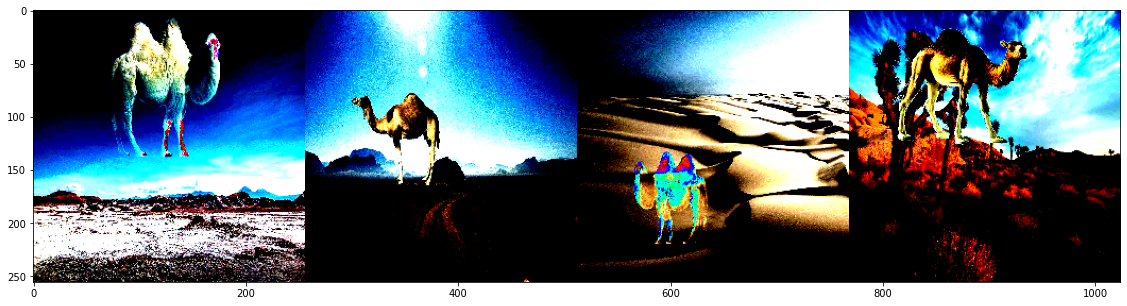

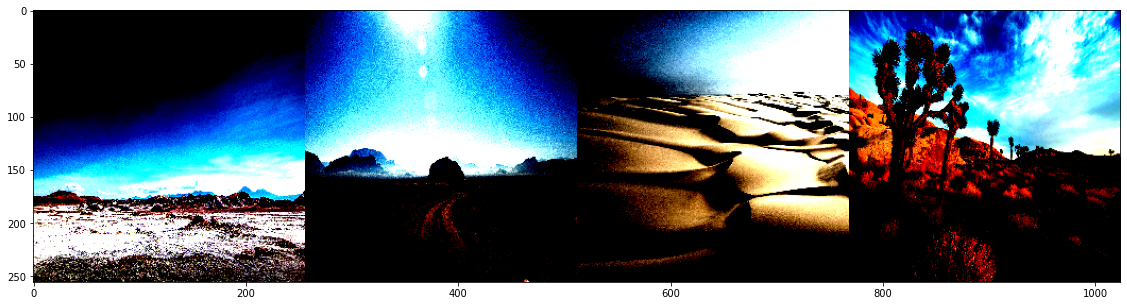

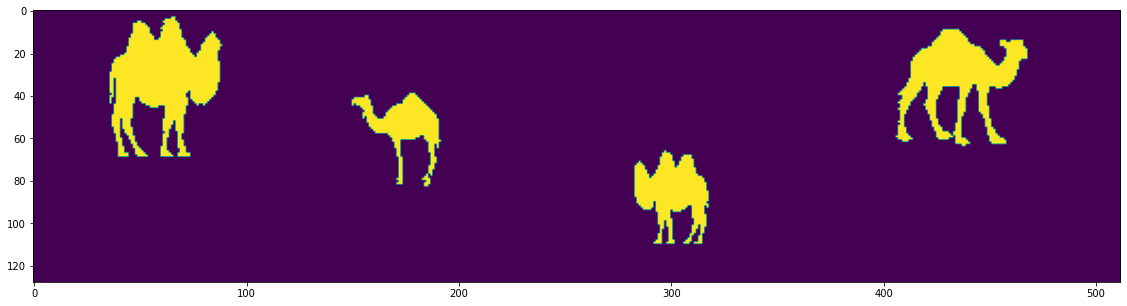

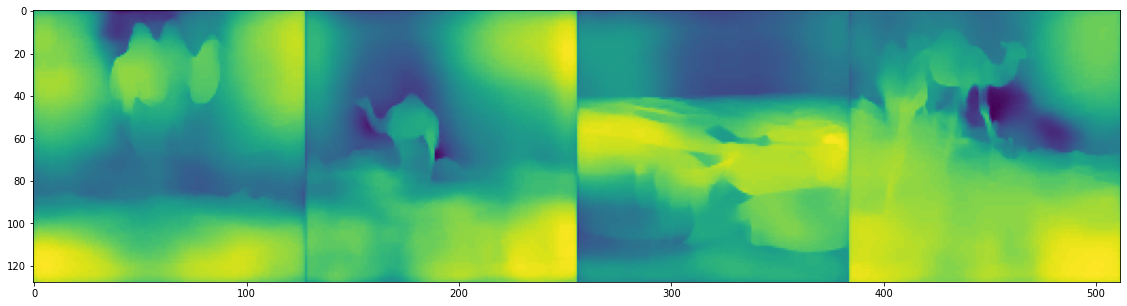

In [0]:
plt.figure(figsize=(20, 5))
plt.imshow(np.hstack(fg_bg_images.permute(0, 2, 3, 1)), cmap='jet')

plt.figure(figsize=(20, 5))
plt.imshow(np.hstack(bg_images.permute(0, 2, 3, 1)), cmap='jet')

# plt.figure(figsize=(20, 5))
# plt.imshow(np.hstack(mask_images.permute(0, 2, 3, 1))[:, :, 0])

# plt.figure(figsize=(20, 5))
# plt.imshow(np.hstack(depth_images.permute(0, 2, 3, 1))[:, :, 0])

plt.figure(figsize=(20, 5))
plt.imshow(np.hstack(mask_minimal_images.permute(0, 2, 3, 1) > 0.0)[:, :, 0])

plt.figure(figsize=(20, 5))
plt.imshow(np.hstack(depth_minimal_images.permute(0, 2, 3, 1))[:, :, 0])

# Model

In [0]:
# Subclassing nn.Module for neural networks
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # _droput = 0.00
        #########################################################################################
        # INPUT BLOCK
        #########################################################################################
        self.double_conv_down0 = nn.Sequential(
            nn.Conv2d(in_channels=6, out_channels=64, kernel_size=(3, 3), padding=(1, 1), bias=False),
            nn.BatchNorm2d(64), 
            nn.ReLU(),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=(3, 3), padding=(1, 1), bias=False),
            nn.BatchNorm2d(64), 
            nn.ReLU()
            # nn.Dropout(_droput)
        )
        self.pool0 = nn.Sequential(
            nn.MaxPool2d(2, 2)
        )
        
        #########################################################################################
        # DOUBLE CONVOLUTION BLOCK DOWN 1
        #########################################################################################
        self.double_conv_down1 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=(3, 3), padding=(1, 1), bias=False),
            nn.BatchNorm2d(64), 
            nn.ReLU(),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=(3, 3), padding=(1, 1), bias=False),
            nn.BatchNorm2d(64), 
            nn.ReLU()
            # nn.Dropout(_droput)
        )
        self.pool1 = nn.Sequential(
            nn.MaxPool2d(2, 2)
        )
        
        #########################################################################################
        # DOUBLE CONVOLUTION BLOCK DOWN 2
        #########################################################################################
        self.double_conv_down2 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=(3, 3), padding=(1, 1), bias=False),
            nn.BatchNorm2d(128), 
            nn.ReLU(),
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=(3, 3), padding=(1, 1), bias=False),
            nn.BatchNorm2d(128), 
            nn.ReLU()
            # nn.Dropout(_droput)
        )
        
        self.pool2 = nn.Sequential(
            nn.MaxPool2d(2, 2)
        )
        
        #########################################################################################
        # DOUBLE CONVOLUTION BLOCK DOWN 3
        #########################################################################################
        self.double_conv_down3 = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=(3, 3), padding=(1, 1), bias=False),
            nn.BatchNorm2d(128), 
            nn.ReLU(),
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=(3, 3), padding=(1, 1), bias=False),
            nn.BatchNorm2d(128), 
            nn.ReLU()
            # nn.Dropout(_droput)
        )
        self.pool3 = nn.Sequential(
            nn.MaxPool2d(2, 2)
        )

        #########################################################################################
        # DOUBLE CONVOLUTION BLOCK DOWN 4
        #########################################################################################
        self.double_conv_down4 = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=(3, 3), padding=(1, 1), bias=False),
            nn.BatchNorm2d(256), 
            nn.ReLU(),
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=(3, 3), padding=(1, 1), bias=False),
            nn.BatchNorm2d(256), 
            nn.ReLU()
            # nn.Dropout(_droput)
        )
        self.pool4 = nn.Sequential(
            nn.MaxPool2d(2, 2)
        )

        #########################################################################################
        # DOUBLE CONVOLUTION BLOCK DOWN 5
        #########################################################################################
        self.double_conv_down5 = nn.Sequential(
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=(3, 3), padding=(1, 1), bias=False),
            nn.BatchNorm2d(256), 
            nn.ReLU(),
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=(3, 3), padding=(1, 1), bias=False),
            nn.BatchNorm2d(256), 
            nn.ReLU()
            # nn.Dropout(_droput)
        )

        #########################################################################################
        # UPSAMPLE BLOCK 4
        #########################################################################################
        self.upsample4 = nn.Sequential(
            nn.Upsample(scale_factor=(2, 2), mode='bilinear', align_corners=True)  
            # nn.Dropout(_droput)
        )

        #########################################################################################
        # DOUBLE CONVOLUTION BLOCK UP 4
        #########################################################################################
        self.double_conv_up4 = nn.Sequential(
            nn.Conv2d(in_channels=(256 + 256), out_channels=256, kernel_size=(3, 3), padding=(1, 1), bias=False),
            nn.BatchNorm2d(256), 
            nn.ReLU(),
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=(3, 3), padding=(1, 1), bias=False),
            nn.BatchNorm2d(256), 
            nn.ReLU()
            # nn.Dropout(_droput)
        )

        #########################################################################################
        # UPSAMPLE BLOCK 3
        #########################################################################################
        self.upsample3 = nn.Sequential(
            nn.Upsample(scale_factor=(2, 2), mode='bilinear', align_corners=True)  
            # nn.Dropout(_droput)
        )

        #########################################################################################
        # DOUBLE CONVOLUTION BLOCK UP 3
        #########################################################################################
        self.double_conv_up3 = nn.Sequential(
            nn.Conv2d(in_channels=(256 + 128), out_channels=128, kernel_size=(3, 3), padding=(1, 1), bias=False),
            nn.BatchNorm2d(128), 
            nn.ReLU(),
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=(3, 3), padding=(1, 1), bias=False),
            nn.BatchNorm2d(128), 
            nn.ReLU()
            # nn.Dropout(_droput)
        )

        #########################################################################################
        # UPSAMPLE BLOCK 2
        #########################################################################################
        self.upsample2 = nn.Sequential(
            nn.Upsample(scale_factor=(2, 2), mode='bilinear', align_corners=True)  
            # nn.Dropout(_droput)
        )

        #########################################################################################
        # DOUBLE CONVOLUTION BLOCK UP 2
        #########################################################################################
        self.double_conv_up2 = nn.Sequential(
            nn.Conv2d(in_channels=(128 + 128), out_channels=128, kernel_size=(3, 3), padding=(1, 1), bias=False),
            nn.BatchNorm2d(128), 
            nn.ReLU(),
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=(3, 3), padding=(1, 1), bias=False),
            nn.BatchNorm2d(128), 
            nn.ReLU()
            # nn.Dropout(_droput)
        )

        #########################################################################################
        # UPSAMPLE BLOCK 1
        #########################################################################################
        self.upsample1 = nn.Sequential(
            nn.Upsample(scale_factor=(2, 2), mode='bilinear', align_corners=True)  
            # nn.Dropout(_droput)
        )

        #########################################################################################
        # DOUBLE CONVOLUTION BLOCK UP 1
        #########################################################################################
        self.double_conv_up1 = nn.Sequential(
            nn.Conv2d(in_channels=(128 + 64), out_channels=64, kernel_size=(3, 3), padding=(1, 1), bias=False),
            nn.BatchNorm2d(64), 
            nn.ReLU(),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=(3, 3), padding=(1, 1), bias=False),
            nn.BatchNorm2d(64), 
            nn.ReLU()
            # nn.Dropout(_droput)
        )

        #########################################################################################
        # MASK HEAD
        #########################################################################################
        self.mask_predictor = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=1, kernel_size=(1, 1), bias=False),
            # nn.BatchNorm2d(256),
            # nn.ReLU(),
            # nn.Dropout(_droput)
        )

        #########################################################################################
        # DEPTH HEAD
        #########################################################################################
        self.depth_predictor = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=1, kernel_size=(1, 1), bias=False),
            # nn.BatchNorm2d(256),
            # nn.ReLU(),
            # nn.Dropout(_droput)
        )

    def blocks(self, x):

        conv0 = self.double_conv_down0(x)
        x = self.pool0(conv0)

        conv1 = self.double_conv_down1(x)
        x = self.pool1(conv1) 

        conv2 = self.double_conv_down2(x)
        x = self.pool2(conv2) 

        conv3 = self.double_conv_down3(x)
        x = self.pool3(conv3) 

        conv4 = self.double_conv_down4(x)
        x = self.pool4(conv4) 

        x = self.double_conv_down5(x)

        x = self.upsample4(x)
        x = torch.cat([x, conv4], dim=1)
        x = self.double_conv_up4(x)

        x = self.upsample3(x)
        x = torch.cat([x, conv3], dim=1)
        x = self.double_conv_up3(x)

        x = self.upsample2(x)
        x = torch.cat([x, conv2], dim=1)
        x = self.double_conv_up2(x)

        x = self.upsample1(x)
        x = torch.cat([x, conv1], dim=1)
        x = self.double_conv_up1(x)

        # Mask prediction
        x1 = self.mask_predictor(x)
        x1 = torch.flatten(x1, 1, 2)

        # Depth map prediction        
        x2 = self.depth_predictor(x) 
        x2 = torch.flatten(x2, 1, 2)
        
        return x1, x2

    def forward(self, x):
        
        x1, x2 = self.blocks(x)
        
        return x1, x2

# Summary

In [0]:
model = Net()
summary(model, input_size=(6, 256, 256), batch_size=4, device='cpu')

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [4, 64, 256, 256]           3,456
       BatchNorm2d-2          [4, 64, 256, 256]             128
              ReLU-3          [4, 64, 256, 256]               0
            Conv2d-4          [4, 64, 256, 256]          36,864
       BatchNorm2d-5          [4, 64, 256, 256]             128
              ReLU-6          [4, 64, 256, 256]               0
         MaxPool2d-7          [4, 64, 128, 128]               0
            Conv2d-8          [4, 64, 128, 128]          36,864
       BatchNorm2d-9          [4, 64, 128, 128]             128
             ReLU-10          [4, 64, 128, 128]               0
           Conv2d-11          [4, 64, 128, 128]          36,864
      BatchNorm2d-12          [4, 64, 128, 128]             128
             ReLU-13          [4, 64, 128, 128]               0
        MaxPool2d-14            [4, 64,

In [0]:
!rm -rf run*/

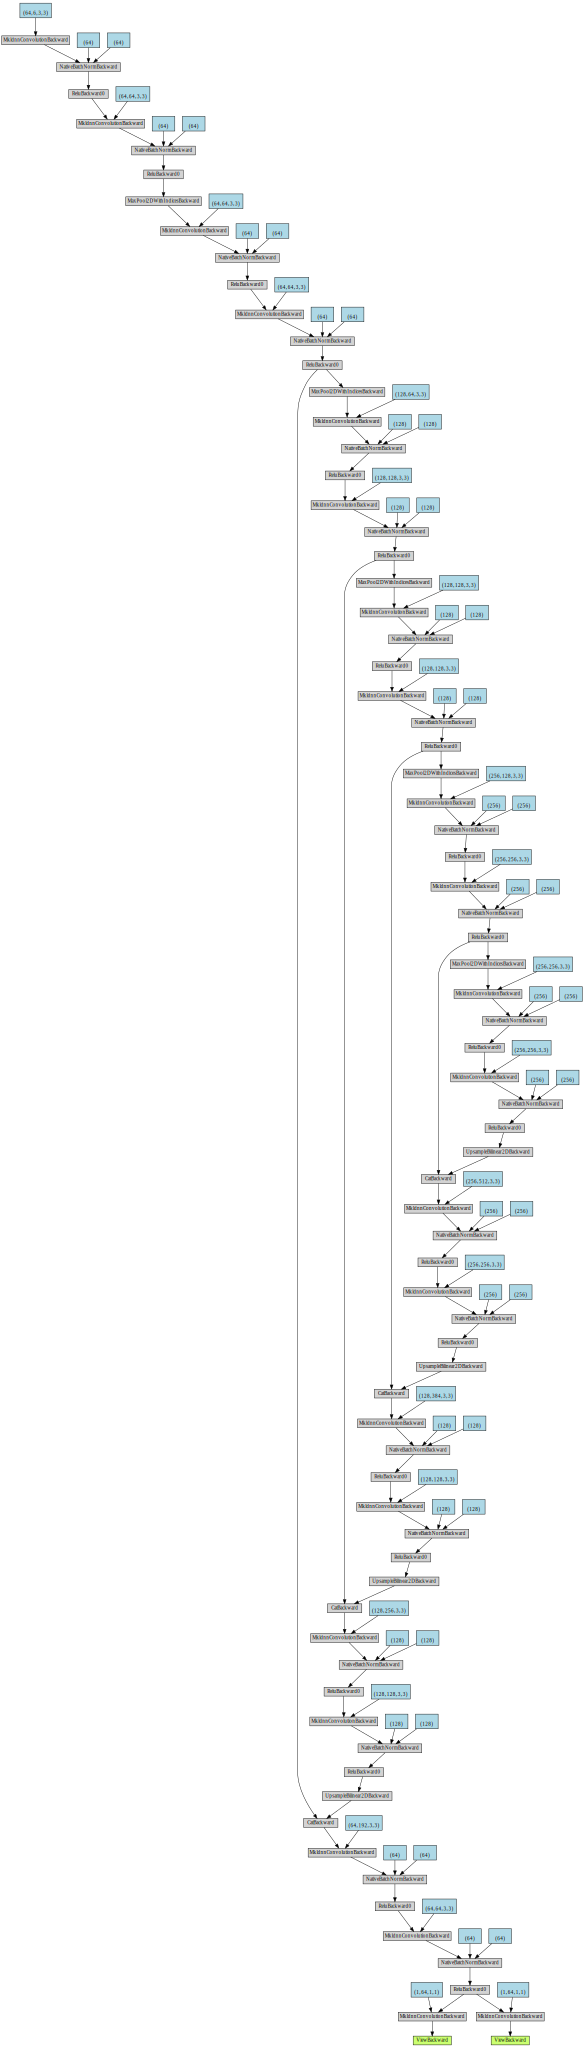

In [0]:
random_input = torch.randn(1, 6, 128, 128)
model.eval()
y = model(Variable(random_input))
dot_graph = make_dot(y)
dot_graph.format = 'svg'
dot_graph.render(f'{experiment_name}')
dot_graph

# Training

In [0]:
def train(model, device, train_loader, optimizer, epoch, writer, scheduler=None):
    model.train()
    dataset.set_train()
    train_loss = 0
    pbar = tqdm(train_loader)
    train_len = len(train_loader.dataset)
    n_train_batches = train_len / batch_size

    ssim_loss = SSIM(window_size=11, reduction='mean')
    ssim_acc = SSIM(window_size=11, reduction='sum')
    
    train_loss, cm_loss, d_loss, acc1, acc2 = 0, 0, 0, 0, 0

    for batch_idx, batch in enumerate(pbar):

        fg_bg_images = batch['fg_bg']
        bg_images = batch['bg']
        mask_images = batch['mask']
        depth_images = batch['depth']
        mask_minimal_images = batch['mask_minimal']
        depth_minimal_images = batch['depth_minimal']

        fg_bg_stacked = torch.cat([fg_bg_images, bg_images], axis=1)

        # Move data to cpu/gpu based on input
        fg_bg_stacked = fg_bg_stacked.to(device)

        optimizer.zero_grad()

        target_mask = torch.squeeze(mask_minimal_images, 1).to(device)
        target_mask = (target_mask > 0.5).float()
        
        target_depth_map = depth_minimal_images.to(device)

        # Forward pass
        output_mask, output_depth_map = model(fg_bg_stacked)

        # Loss computation

        camel_mask_loss = F.binary_cross_entropy_with_logits(output_mask, target_mask, reduction='mean')
        
        # Loss computation
        c_camel_mask_loss, c_depth_map_ssim, c_depth_map_l1 = 1e1, 1e2, 1e-1

        dssim_loss = ssim_loss(output_depth_map.unsqueeze(1), target_depth_map)

        depth_l1_loss = torch.abs(output_depth_map.unsqueeze(1) - target_depth_map).mean()
        depth_map_loss =  c_depth_map_ssim * dssim_loss + c_depth_map_l1 * depth_l1_loss

        batch_loss = (c_camel_mask_loss * camel_mask_loss) + \
                     depth_map_loss

        train_loss += (batch_loss / n_train_batches).item()
        cm_loss += (camel_mask_loss / n_train_batches).item()
        d_loss += (depth_map_loss / n_train_batches).item()
        
        # Backward pass)
        batch_loss.backward()
        
        # Gradient descent
        optimizer.step()
        
        acc1 += (torch.round(torch.sigmoid(output_mask)).eq(target_mask).float().mean() / n_train_batches).item()
        acc2 += ((1 - dssim_loss) / n_train_batches).item()


        # Step scheduler if scheduler is present
        if scheduler:
            scheduler.step()
        
        # Logging - updating progress bar and summary writer
        pbar.set_description(desc= f'TRAIN : epoch={epoch} dsssim: {dssim_loss:5f} ' +
                                   f'mask_acc: {100 * acc1:.2f} depth_acc: {100 * acc2:.2f} ' +
                                   f'loss: {train_loss:.5f} cm_loss={cm_loss:.5f} d_loss={d_loss:.5f}')

        writer.add_scalar('train/batch_loss', batch_loss, epoch * train_len + batch_idx)
    writer.add_scalar('loss', train_loss, epoch)

    return train_loss, np.mean([acc1, acc2])

# Testing

In [0]:
def test(model, device, test_loader, epoch, writer):

    model.eval()
    dataset.set_eval()
    pbar = tqdm(test_loader)
    test_len = len(test_loader.dataset)
    n_test_batches = test_len / batch_size

    ssim_loss = SSIM(window_size=11, reduction='mean')
    ssim_acc = SSIM(window_size=11, reduction='sum')
    
    test_loss, cm_loss, d_loss, acc1, acc2 = 0, 0, 0, 0, 0

    for batch_idx, batch in enumerate(pbar):

        fg_bg_images = batch['fg_bg']
        bg_images = batch['bg']
        mask_images = batch['mask']
        depth_images = batch['depth']
        mask_minimal_images = batch['mask_minimal']
        depth_minimal_images = batch['depth_minimal']

        fg_bg_stacked = torch.cat([fg_bg_images, bg_images], axis=1)

        # Move data to cpu/gpu based on input
        fg_bg_stacked = fg_bg_stacked.to(device)

        target_mask = torch.squeeze(mask_minimal_images, 1).to(device)
        target_mask = (target_mask > 0.5).float()
        
        target_depth_map = depth_minimal_images.to(device)

        # Forward pass
        output_mask, output_depth_map = model(fg_bg_stacked)

        # Loss computation
        camel_mask_loss = F.binary_cross_entropy_with_logits(output_mask, target_mask, reduction='mean')

        c_camel_mask_loss, c_depth_map_ssim, c_depth_map_l1 = 1e1, 1e2, 1e-1

        dssim_loss = ssim_loss(output_depth_map.unsqueeze(1), target_depth_map)

        depth_l1_loss = torch.abs(output_depth_map.unsqueeze(1) - target_depth_map).mean()
        depth_map_loss = c_depth_map_ssim * dssim_loss + c_depth_map_l1 * depth_l1_loss

        batch_loss = (c_camel_mask_loss * camel_mask_loss) + \
                     depth_map_loss

        test_loss += (batch_loss / n_test_batches).item()
        cm_loss += (camel_mask_loss / n_test_batches).item()
        d_loss += (depth_map_loss / n_test_batches).item()
        
        acc1 += (torch.round(torch.sigmoid(output_mask)).eq(target_mask).float().mean() / n_test_batches).item()
        acc2 += ((1 - dssim_loss) / n_test_batches).item()
        
        # Logging - updating progress bar and summary writer
        pbar.set_description(desc= f'TEST : epoch={epoch} dssim: {dssim_loss:.5f} ' +
                                   f'mask_acc: {100 * acc1:.2f} depth_acc: {100 * acc2:.2f} ' +
                                   f'loss: {test_loss:.5f} cm_loss={cm_loss:.5f} d_loss={d_loss:.5f}')

        writer.add_scalar('test/batch_loss', batch_loss, epoch * test_len + batch_idx)
    writer.add_scalar('loss', test_loss, epoch)
    return test_loss, np.mean([acc1, acc2])

In [0]:
torch.cuda.empty_cache()

In [0]:
!rm -rf run*/

In [0]:
model = Net()
model = model.to(device)

In [0]:
tqdm._instances.clear()

In [97]:
now = datetime.datetime.now()
prefix = now.strftime('%m-%d-%y %H:%M:%S')

train_dir_suffix = f'/content/drive/My Drive/log_{experiment_name}/run_train_{experiment_name}'
test_dir_suffix = f'/content/drive/My Drive/log_{experiment_name}/run_test_{experiment_name}'

model_dir_suffix = f'/content/drive/My Drive/model_{experiment_name}'

train_dir = f'{train_dir_suffix}_{prefix}'
test_dir = f'{test_dir_suffix}_{prefix}'

train_writer = SummaryWriter(train_dir)
test_writer = SummaryWriter(test_dir)

lr = 1e-3
epochs = 5
momentum = 0.7

optimizer = optim.Adam(model.parameters(), lr=lr, amsgrad=True)
# optimizer = optim.SGD(model.parameters(), lr=lr, momentum=momentum)

# scheduler = CyclicLR(optimizer, base_lr=0.0001, max_lr=0.01, step_size_up=1500)
# scheduler = StepLR(optimizer, step_size=5, gamma=0.1)

best_test_accuracy = 0
best_test_loss = float('inf')
best_model_path = ''

for epoch in range(0, epochs):
    
    train_loss, train_accuracy = train(model, device, train_dataloader, optimizer, epoch, train_writer, scheduler=None)
    test_loss, test_accuracy = test(model, device, test_dataloader, epoch, test_writer)
    
    if test_accuracy > best_test_accuracy:
        best_model_path = f'{model_dir_suffix}/acc_{best_test_accuracy:2.2f}_epoch_{epoch}.pth'
        torch.save(model, best_model_path)
        
        best_test_accuracy = test_accuracy 
        best_test_loss = test_loss

    # scheduler.step()

TRAIN : epoch=0 dsssim: 0.146604 mask_acc: 99.60 depth_acc: 85.28 loss: 14.84216 cm_loss=0.01043 d_loss=14.73783: 100%|██████████| 7500/7500 [33:19<00:00,  3.75it/s]
TEST : epoch=0 dssim: 0.27266 mask_acc: 97.43 depth_acc: 74.05 loss: 26.95518 cm_loss=0.09672 d_loss=25.98796: 100%|██████████| 2500/2500 [08:40<00:00,  4.80it/s]
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:402: UserWarning: Couldn't retrieve source code for container of type Net. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
TRAIN : epoch=1 dsssim: 0.104214 mask_acc: 99.64 depth_acc: 85.97 loss: 14.14543 cm_loss=0.00921 d_loss=14.05333: 100%|██████████| 7500/7500 [33:23<00:00,  3.74it/s]
TEST : epoch=1 dssim: 0.29243 mask_acc: 98.50 depth_acc: 73.45 loss: 27.12203 cm_loss=0.05271 d_loss=26.59495: 100%|██████████| 2500/2500 [08:32<00:00,  4.88it/s]
TRAIN : epoch=2 dsssim: 0.123924 mask_acc: 99.65 depth_acc: 86.44 loss: 13.67147 cm_loss=0.00883 d_loss

In [0]:
batch_size = 16
dataloader_args = dict(shuffle=True, batch_size=batch_size, num_workers=4, pin_memory=True) if use_cuda else dict(shuffle=True, batch_size=batch_size)
_data_loader = torch.utils.data.DataLoader(dataset, **dataloader_args, drop_last=True)

In [0]:
data_iter = iter(_data_loader)
batch = next(data_iter)

fg_bg_images_in = batch['fg_bg'].to(device)
bg_images_in = batch['bg'].to(device)

fg_bg_stacked = torch.cat([fg_bg_images_in, bg_images_in], axis=1)

output_mask, output_depth_map = model(fg_bg_stacked)
output_mask = torch.sigmoid(output_mask).cpu().detach().numpy()
output_depth_map = output_depth_map.cpu().detach().numpy()
fg_bg_images_in, bg_images_in = fg_bg_images_in.cpu(), bg_images_in.cpu()

In [99]:
output_mask.shape, output_depth_map.shape

((4, 128, 128), (4, 128, 128))

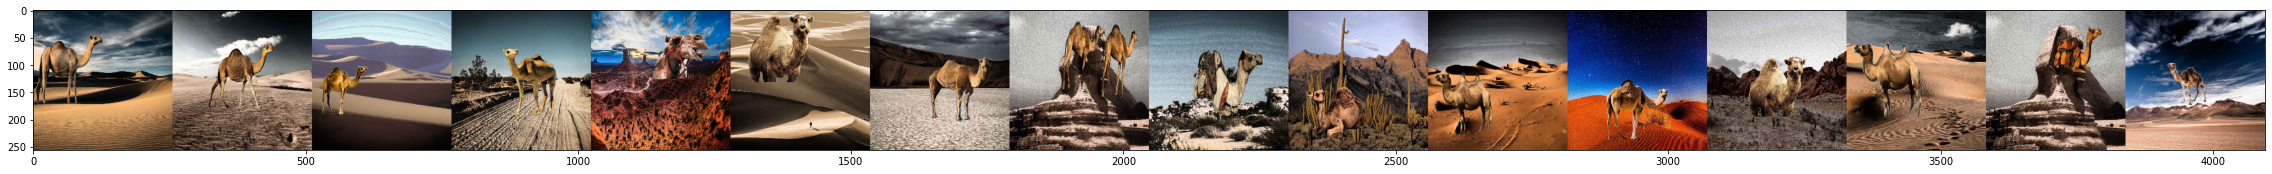

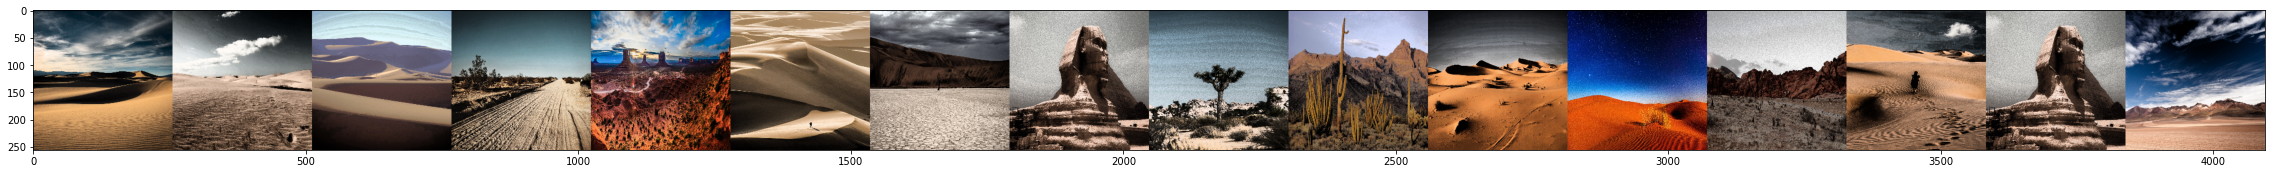

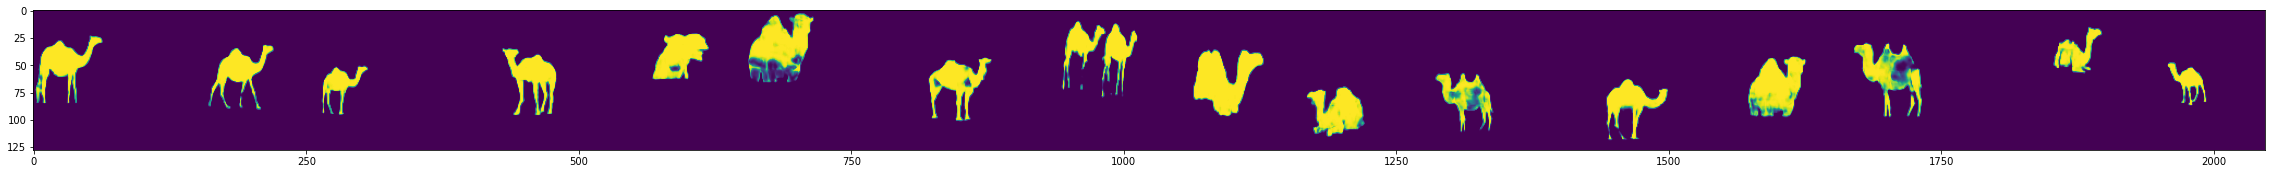

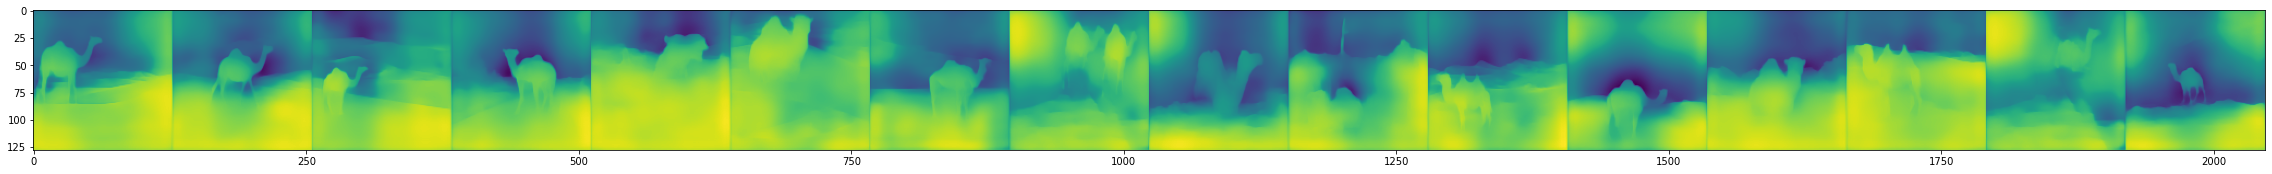

In [120]:
plt.figure(figsize=(40, 10))
plt.imshow(np.hstack(fg_bg_images_in.permute(0, 2, 3, 1)), cmap='jet')

plt.figure(figsize=(40, 10))
plt.imshow(np.hstack(bg_images_in.permute(0, 2, 3, 1)), cmap='jet')

plt.figure(figsize=(40, 10))
plt.imshow(np.hstack(output_mask))

plt.figure(figsize=(40, 10))
plt.imshow(np.hstack(output_depth_map))